# Libraries, Headers and Stuff

In [1]:
import sys
sys.path.append('../../src')

In [2]:
TEST_RATIO = .05

N_STATES = 128
N_EPOCHS = 50
BATCH_SIZE = 32

MAX_VOCAB_SIZE = -1
MAX_SEQUENCE_SIZE = -1

LAYERS_TO_CHECK = [0,1]

import scores
METRIC = scores.Correlation()

SAMPLES_VERIFY = 8

In [3]:
import datetime
import os

FOLDER_OUT = 'Linux2-' + str(datetime.datetime.today())
if not os.path.exists(FOLDER_OUT):
    os.makedirs(FOLDER_OUT)

In [4]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


In [5]:
%load_ext rpy2.ipython

In [6]:
import random
random.seed(55555)

# Loads Model

In [7]:
import kernelhelpers
reload(kernelhelpers)

num_layer = 2

path = 'corpus/linux_kernel_val.txt'
model_weights = 'models/corpus_linux_kernel_val_architecture_stateful_type_char_layers_2_hidden_units_128_epoch_49_weights.h5'
model_settings_name = 'settings/corpus_linux_kernel_architecture_stateful_type_char_layers_2_hidden_units_128_settings.pickle'
new_batch_size = BATCH_SIZE
new_size = 1
new_time_skip = 1
is_stateful = True

# Loads the model
model,char2int,int2char,model_type = \
    kernelhelpers.load_setup(num_layer,
                path,
                model_weights,
                model_settings_name ,
                new_batch_size,
                new_size,
                new_time_skip,
                is_stateful)

128
lstm_2
128
lstm_3
Loading model settings/corpus_linux_kernel_architecture_stateful_type_char_layers_2_hidden_units_128_settings.pickle
type: basic_architecture


In [8]:
for layer in model.layers:
    print layer

# Creates dataset

In [9]:
raw_data = kernelhelpers.get_corpus('corpus/linux_input.txt')

print 'Number of charaters', len(raw_data)
print 'Number of charaters', len(set(raw_data))

Reading file corpus/linux_input.txt
Number of Words in Current Corpus: 6206996
Number of charaters 6206996
Number of charaters 75


In [10]:
import utils.preprocess as pre

# Generates data
full_size = len(raw_data)
train_size = int((1-TEST_RATIO) * full_size)

train_sequence = raw_data[:train_size]
test_sequence = raw_data[train_size:]

raw_train_sequence = [char2int[c] for c in train_sequence]
raw_test_sequence  = [char2int[c] for c in test_sequence]

# If necessary, truncates:
if MAX_SEQUENCE_SIZE > 0:
    train_size = int(MAX_SEQUENCE_SIZE * (1-TEST_RATIO))
    test_size = int(MAX_SEQUENCE_SIZE * TEST_RATIO)
    raw_train_sequence = raw_train_sequence[:train_size]
    raw_test_sequence  = raw_test_sequence[:test_size]

print 'Training smybols:', len(raw_train_sequence)
print 'Testing smybols:', len(raw_test_sequence)
print 'Size vocabulay:', len(char2int)

Training smybols: 5896646
Testing smybols: 310350
Size vocabulay: 75


In [11]:
import numpy as np
import utils.preprocess as pre
reload(pre)

# Preprocesses training
# SPLITS
X_train_raw = raw_train_sequence[:-1]
y_train_raw = raw_train_sequence[1:]
# ENCODES
X_train = pre.one_hot_encode_seq(X_train_raw, n_chars=len(int2char))
y_train = pre.one_hot_encode_seq(y_train_raw, n_chars=len(int2char))
# SHUFFLES
train_indices = pre.shuffle_indices(len(X_train_raw), BATCH_SIZE)
y_train = y_train[train_indices]
# EXPANDS
X_train = X_train[train_indices,np.newaxis,:]

# Preprocesses testing
# SPLITS
X_test_raw = raw_test_sequence[:-1]
y_test_raw = raw_test_sequence[1:]
# ENCODES
X_test = pre.one_hot_encode_seq(X_test_raw, n_chars=len(int2char))
y_test = pre.one_hot_encode_seq(y_test_raw, n_chars=len(int2char))
# SHUFFLES
test_indices = pre.shuffle_indices(len(X_test_raw), BATCH_SIZE)
X_test = X_test[test_indices, np.newaxis,:]
y_test = y_test[test_indices]

print "Training data:"
print "X:", X_train.shape
print "y:", y_train.shape

print "Test data:"
print "X:", X_test.shape
print "y:", y_test.shape

# Recovers the original training data
X_test_sequence = test_sequence[:X_test.shape[0]]
y_test_sequence = test_sequence[1:X_test.shape[0]+1]
print 'Test sequences:', X_test_sequence[:5], y_test_sequence[:5]
print 'length:', len(X_test_sequence), len(y_test_sequence)

Training data:
X: (5896640, 1, 75)
y: (5896640, 75)
Test data:
X: (310336, 1, 75)
y: (310336, 75)
Test sequences: ['d', 'a', 'y', ',', '\n'] ['a', 'y', ',', '\n', '\t']
length: 310336 310336


# Evaluate

In [12]:
model.reset_states()
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

309952/310336 [============================>.] - ETA: 0s('Test score:', 1.333730922458368)
('Test accuracy:', 0.62974969065786757)


In [13]:
# Generate samples
import generator as gen
reload(gen)

print gen.complete_sentence_stateful('if ', model, 256, char2int, int2char, BATCH_SIZE)
print '*****'
print gen.complete_sentence_stateful('else', model, 256, char2int, int2char, BATCH_SIZE)

Dimensions of sentence after encoding: (32, 3, 75)
Dimensions of sentence after generation: (32, 260, 75)
if * fd freed unreghor+here set anvaly
vireachingh r tasklet the processes temporary in freezing trace/handler pointer */
		tick_brocked_stack(&rb->aux_nr_state);
	}
	rb->trace_cpuset += null;
	tp->rcu_balk_rb = rtws_stack = 0;

	/* save progress waity with la
*****
Dimensions of sentence after encoding: (32, 4, 75)
Dimensions of sentence after generation: (32, 261, 75)
elsesactive everywmapped).    these
	 * that read know waits, */ version.
	 * that len xtroups are recursion */
	if (stall_smp_ops != rcu_control_safe__vised(remove_enabled))
		return 0;
	return 1;
}

/*
 * save the cpu include the free software; upiding events


# Extracts features

In [14]:
import features as feat
reload(feat)

#alphabet = feat.alphabet()

brackets = feat.is_enclosed_bin('(', ')')
curly_brackets = feat.is_enclosed_bin('{', '}')
linepos = feat.line_char_pos_bin()
comments = feat.is_enclosed_str_nodepth('/*','*/')
quotes = feat.is_enclosed_str_nodepth('"', '"')
indent = feat.line_indent_level()
word_hash = feat.char_word_hash(5)
alphanum = feat.alphanum()
word_limits = feat.word_start_end()

r1 = feat.regex('return')
r2 = feat.regex('struct')
r3 = feat.regex('e')
r4 = feat.regex('\d')
r5 = feat.regex('\s')
r6 = feat.regex('\n')
r7 = feat.regex('if\s*\(.*\)')
r8 = feat.regex('for\s*\(.*\)')

features = [linepos, brackets, curly_brackets, comments, 
            indent, word_hash, quotes, alphanum, word_limits,
            r1, r2, r3, r4, r5, r6, r7, r8]

In [15]:
reload(feat)

feature_frame_x = feat.FeatureFrame(features, X_test_sequence)
feature_frame_x.extract()

feature_frame_y = feat.FeatureFrame(features, y_test_sequence)
feature_frame_y.extract()

print'Features for test sequence:'
print feature_frame_x.names
print feature_frame_x.values[:25,:]

print 'Features for test sequence labels:'
print feature_frame_y.names
print feature_frame_y.values[:25,:]

Generating feature scores
Running feature 0 out of 17
Added features ['pos0_10', 'pos10_20', 'pos20_30', 'pos30_40', 'pos40_50', '...']
Running feature 1 out of 17
Added features ["dep_'('')'_1", "dep_'('')'_2", "dep_'('')'_3"]
Running feature 2 out of 17
Added features ["dep_'{''}'_1", "dep_'{''}'_2", "dep_'{''}'_3", "dep_'{''}'_4", "dep_'{''}'_5", '...']
Running feature 3 out of 17
Added features ["enc_'/*''*/'"]
Running feature 4 out of 17
Added features ['indent0', 'indent1', 'indent2', 'indent3', 'indent4', '...']
Running feature 5 out of 17
Added features ['n_gram_0', 'n_gram_1', 'n_gram_2', 'n_gram_3', 'n_gram_4', '...']
Running feature 6 out of 17
Added features ['enc_\'"\'\'"\'']
Running feature 7 out of 17
Added features ['is_alphanum']
Running feature 8 out of 17
Added features ['word_lim']
Running feature 9 out of 17
Added features ["expr'return'"]
Running feature 10 out of 17
Added features ["expr'struct'"]
Running feature 11 out of 17
Added features ["expr'e'"]
Running fe

# Extracts hidden states

In [16]:
import extractor
reload(extractor)
    
ex=extractor.Extractor(model, LAYERS_TO_CHECK)
states = ex.get_states(X_test, batch_size=BATCH_SIZE, unshuffle=True)
nn_config = ex.get_structure()
nn_offsets = ex.get_offets()

print 'states shape:', states.shape
print 'config:', nn_config
print 'offets:', nn_offsets

BEWARE _ ONLY SUPPORTS CONSECUTIVE LAYER IDS STARTING AT 0
Creates spy models
... for id 0 : <controllers.mylstm_legacy.MYLSTM object at 0x11f497750>
... for id 1 : <controllers.mylstm_legacy.MYLSTM object at 0x11f497ad0>
Gets the activations for the hidden states
Gets structure
Gets offets
WARNING +++ NOT SUITABLE FOR NON_FORWARD LAYERS
Gets structure
states shape: (310336, 256)
config: [('<controllers.mylstm_legacy.MYLSTM object at 0x11f497750>', 1, 128), ('<controllers.mylstm_legacy.MYLSTM object at 0x11f497ad0>', 1, 128)]
offets: {(1, 0): 0, (0, 0): 0}


In [17]:
feat_names, feat_mat = feature_frame_x.data

In [ ]:
%%R -i feat_names,feat_mat,states,X_test_sequence,FOLDER_OUT

library(ggplot2)
library(scales)
library(dplyr)
library(tidyr)

states_col_names <- paste0('_', 0:(ncol(states)-1))
colnames(states) <- states_col_names
colnames(feat_mat) <- feat_names

to_plot <- cbind(states, feat_mat)
to_plot <- as.data.frame(to_plot)
to_plot[['time']] <- 1:nrow(to_plot)
to_plot <-  gather(to_plot, key='Series', value='Value', -time)
to_plot[['is_a_feature']] <- ! to_plot$Series %in% states_col_names

to_plot <- filter(to_plot, Series %in%states_col_names | is_a_feature)
MAX_TIME <- 150 
to_plot <- filter(to_plot, time <= MAX_TIME)

labels <- X_test_sequence[1:MAX_TIME]
print(labels)

p <- ggplot(to_plot, aes(x=time, y=Value, fill=is_a_feature, color=is_a_feature, shape = is_a_feature)) +
            scale_x_continuous(breaks = sort(unique(to_plot$time)), labels = labels) +
            #scale_y_continuous(limits = c(-1,1), breaks=c(-1,1)) +
            geom_line() +
            geom_point() +
            facet_grid(Series~., scales="free")

ggsave(paste0(FOLDER_OUT, '/activations.pdf'), p, width=40, height=49)

p <- NULL
to_plot <- NULL
states <- NULL
feat_mat <- NULL

/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attachement du package : ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


  [1] "d"  "a"  "y"  ","  "\n" "\t" "\t" "t"  "m"  "."  "t"  "m"  "_"  "h"  "o" 
 [16] "u"  "r"  ","  " "  "t"  "m"  "."  "t"  "m"  "_"  "m"  "i"  "n"  ","  " " 
 [31] "t"  "m"  "."  "t"  "m"  "_"  "s"  "e"  "c"  ","  "\n" "\t" "\t" "s"  "y" 
 [46] "s"  "_"  "t"  "z"  "."  "t"  "z"  "_"  "m"  "i"  "n"  "u"  "t"  "e"  "s" 
 [61] "w"  "e"  "s"  "t"  ")"  ";"  "\n" "\n" "\t" "k"  "d"  "b"  "_"  "s"  "y" 
 [76] "s"  "i"  "n"  "f"  "o"  "("  "&"  "v"  "a"  "l"  ")"  ";"  "\n" "\t" "k" 
 [91] "d"  "b"  "_"  "p"  "r"  "i"  "n"  "t"  "f"  "("  "\"" "u"  "p"  "t"  "i" 
[106] "m"  "e"  " "  " "  " "  " "  " "  "\"" ")"  ";"  "\n" "\t" "i"  "f"  " " 
[121] "("  "v"  "a"  "l"  "."  "u"  "p"  "t"  "i"  "m"  "e"  " "  ">"  " "  "(" 
[136] "2"  "4"  "*"  "6"  "0"  "*"  "6"  "0"  ")"  ")"  " "  "{"  "\n" "\t" "\t"


In [ ]:
%%R -i feat_names,feat_mat,states,X_test_sequence,FOLDER_OUT

library(ggplot2)
library(scales)
library(dplyr)
library(tidyr)

states_col_names <- paste0('_', 0:(ncol(states)-1))
colnames(states) <- states_col_names
colnames(feat_mat) <- feat_names

to_plot <- cbind(states, feat_mat)
to_plot <- as.data.frame(to_plot)
to_plot[['time']] <- 1:nrow(to_plot)
to_plot <-  gather(to_plot, key='Series', value='Value', -time)

MAX_TIME <- 3000 
to_plot <- filter(to_plot, time <= MAX_TIME)

to_plot$Value <- round(to_plot$Value, 2)
write.csv(to_plot, paste0(FOLDER_OUT, '/activations.csv'), row.names = FALSE)

to_plot <- NULL
states <- NULL
feat_mat <- NULL

# Correlation based attribution

In [ ]:
import scores
reload(scores)
import inspector as ip
reload(ip)

insp = ip.Inspector(nn_config, nn_offsets)
mi_scores, names = insp.inspect(states, feature_frame_x, scores.Correlation())

Computing attribution scores
Feture matrix dimensions: (310336, 40)
States dimensions: (310336, 256)
Computing score for feature 0: pos0_10
Layer 0
Timestep 0
Scoring neurons 0 to 127
Layer 1
Timestep 0
Scoring neurons 128 to 255
Computing score for feature 1: pos10_20
Layer 0
Timestep 0
Scoring neurons 0 to 127
Layer 1
Timestep 0
Scoring neurons 128 to 255
Computing score for feature 2: pos20_30
Layer 0
Timestep 0
Scoring neurons 0 to 127
Layer 1
Timestep 0
Scoring neurons 128 to 255
Computing score for feature 3: pos30_40
Layer 0
Timestep 0
Scoring neurons 0 to 127
Layer 1
Timestep 0
Scoring neurons 128 to 255
Computing score for feature 4: pos40_50
Layer 0
Timestep 0
Scoring neurons 0 to 127
Layer 1
Timestep 0
Scoring neurons 128 to 255
Computing score for feature 5: pos50_60
Layer 0
Timestep 0
Scoring neurons 0 to 127
Layer 1
Timestep 0
Scoring neurons 128 to 255
Computing score for feature 6: dep_'('')'_1
Layer 0
Timestep 0
Scoring neurons 0 to 127
Layer 1
Timestep 0
Scoring neuro

In [ ]:
fname = FOLDER_OUT + '/attributions'
hnames = [repr(n) for n in names]
header = ','.join(hnames)
np.savetxt(fname, mi_scores, delimiter=',', header=header, comments='')

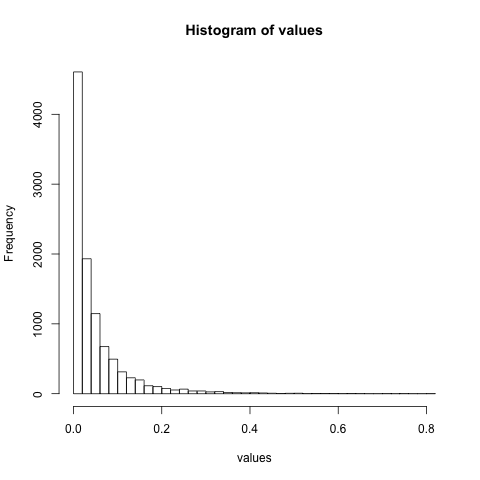

In [ ]:
%%R -i mi_scores
values <- c(mi_scores)
hist(values, breaks=30)
mi_scores <- NULL

In [ ]:
feature_neurons = insp.filter_attributions(ip.filter_threshold_abs(.1))
non_feature_neurons = insp.not_attributed()
feature_neurons

{"dep_'('')'_1": [(0, 0, 9),
  (0, 0, 11),
  (0, 0, 17),
  (0, 0, 19),
  (0, 0, 29),
  (0, 0, 36),
  (0, 0, 41),
  (0, 0, 42),
  (0, 0, 45),
  (0, 0, 50),
  (0, 0, 57),
  (0, 0, 67),
  (0, 0, 69),
  (0, 0, 76),
  (0, 0, 78),
  (0, 0, 85),
  (0, 0, 89),
  (0, 0, 93),
  (0, 0, 105),
  (0, 0, 108),
  (0, 0, 117),
  (0, 0, 119),
  (0, 0, 126),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 0, 3),
  (1, 0, 11),
  (1, 0, 16),
  (1, 0, 23),
  (1, 0, 35),
  (1, 0, 41),
  (1, 0, 44),
  (1, 0, 50),
  (1, 0, 60),
  (1, 0, 69),
  (1, 0, 72),
  (1, 0, 73),
  (1, 0, 85),
  (1, 0, 92),
  (1, 0, 94),
  (1, 0, 98),
  (1, 0, 99),
  (1, 0, 102),
  (1, 0, 120),
  (1, 0, 121)],
 "dep_'('')'_2": [(0, 0, 19),
  (0, 0, 57),
  (0, 0, 85),
  (0, 0, 89),
  (0, 0, 126),
  (1, 0, 1),
  (1, 0, 2),
  (1, 0, 72)],
 "dep_'('')'_3": [],
 "dep_'{''}'_1": [(0, 0, 9),
  (0, 0, 16),
  (0, 0, 17),
  (0, 0, 26),
  (0, 0, 36),
  (0, 0, 37),
  (0, 0, 45),
  (0, 0, 57),
  (0, 0, 84),
  (0, 0, 85),
  (0, 0, 89),
  (0, 0, 93),
  (0

In [ ]:
is_selected = np.zeros_like(mi_scores)
for j, fname in enumerate(names):
    for adress in feature_neurons[fname]:
        i = insp.address_to_column(*adress)
        is_selected[i,j] = 1

In [ ]:
%%R -i mi_scores,names,is_selected,N_STATES,FOLDER_OUT

library(ggplot2)
library(scales) 
library(dplyr)
library(tidyr)

# Gets scores
data <- as.data.frame(mi_scores)
names(data) <- names
data[['Neuron']] <- factor(0:(nrow(data)-1),
                           levels = 0:(nrow(data)-1),
                           labels = as.character(0:(nrow(data)-1)))
data <- gather(data, key='Feature', value='Score', -Neuron)

# Gets neuron selection
sel <- as.data.frame(is_selected)
names(sel) <- names
sel[['Neuron']] <- factor(0:(nrow(sel)-1),
                           levels = 0:(nrow(sel)-1),
                           labels = as.character(0:(nrow(sel)-1)))
sel <- gather(sel, key='Feature', value='selected', -Neuron)
sel$selected <- ifelse(sel$selected == 1, 'X', '')

# joins
to_plot <- inner_join(data,sel, by = c("Neuron", "Feature"))

p <- ggplot(to_plot, aes(x=Feature, y=Neuron, fill=Score, label=selected)) + 
                geom_bin2d(aes='identity') +
                geom_text(color='red') +
                scale_fill_gradient2(midpoint=median(to_plot$Score),
                                    low = muted("blue"), mid = "white",high = muted("red"),
                                    limits=c(0,NA)) +
                theme(axis.text.x = element_text(angle=90))

ggsave(paste0(FOLDER_OUT, '/attribution_map.pdf'), p, width=40, height=40)
p

p <- NULL
mi_scores <- NULL
is_selected <- NULL
data <- NULL
sel <- NULL
to_plot <- NULL

/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Ignoring unknown parameters: aes

  warnings.warn(x, RRuntimeWarning)


# Does the Unit Test

In [ ]:
import scores
out_base = insp.test(states, feature_frame_x, non_feature_neurons, scores.LogRegF1())
out_base

Computing scores for pos30_40
Computing scores for expr'return'
Computing scores for expr'\\s'
Computing scores for indent1
Computing scores for indent0
ERROR Cant compute score: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0
Computing scores for indent3
Computing scores for indent2
Computing scores for indent5
Computing scores for indent4
Computing scores for indent7
Computing scores for indent6
Computing scores for dep_'('')'_1
Computing scores for dep_'('')'_2
Computing scores for dep_'('')'_3
Computing scores for n_gram_4
Computing scores for expr'struct'
Computing scores for n_gram_1
Computing scores for n_gram_0
Computing scores for n_gram_3
Computing scores for n_gram_2
Computing scores for enc_'/*''*/'
Computing scores for dep_'{''}'_5
Computing scores for dep_'{''}'_4
Computing scores for dep_'{''}'_3
Computing scores for dep_'{''}'_2
Computing scores for dep_'{''}'_1
Computing scores for pos40_50
Computing scores for enc

{"dep_'('')'_1": 0.7308625869182066,
 "dep_'('')'_2": 0.24848792210034634,
 "dep_'('')'_3": 0.044927779159222782,
 "dep_'{''}'_1": 0.80328233742342425,
 "dep_'{''}'_2": 0.47060114407399839,
 "dep_'{''}'_3": 0.18500494836674788,
 "dep_'{''}'_4": 0.055802200102876405,
 "dep_'{''}'_5": 0.25483551748761724,
 'enc_\'"\'\'"\'': 0.20204192127866671,
 "enc_'/*''*/'": 0.75259741367874755,
 "expr'\\\\d'": 0.97592896475505164,
 "expr'\\\\s'": 0.71385891266276191,
 "expr'\\n'": 0.97922576148664786,
 "expr'e'": 0.81220259536067874,
 "expr'for\\\\s*\\\\(.*\\\\)'": 0.11204798200516948,
 "expr'if\\\\s*\\\\(.*\\\\)'": 0.43781252999752934,
 "expr'return'": 0.84038312033819917,
 "expr'struct'": 0.82854512697080551,
 'indent0': 0,
 'indent1': 0.8078612290270103,
 'indent2': 0.53594062786750796,
 'indent3': 0.27278207512450631,
 'indent4': 0.1203874574562474,
 'indent5': 0.061123156250176613,
 'indent6': 0.029688884872428472,
 'indent7': 0.10925571027156457,
 'indent8': 0.20662083759933694,
 'is_alphanum':

In [ ]:
# With the correct neuronss 
out = insp.test(states, feature_frame_x, feature_neurons, scores.LogRegF1())
out

Computing scores for pos30_40
Computing scores for expr'return'
Computing scores for expr'\\s'
Computing scores for indent1
Computing scores for indent0
ERROR Cant compute score: Found array with 0 feature(s) (shape=(310336, 0)) while a minimum of 1 is required.
Computing scores for indent3
Computing scores for indent2
Computing scores for indent5
ERROR Cant compute score: Found array with 0 feature(s) (shape=(310336, 0)) while a minimum of 1 is required.
Computing scores for indent4
Computing scores for indent7
ERROR Cant compute score: Found array with 0 feature(s) (shape=(310336, 0)) while a minimum of 1 is required.
Computing scores for indent6
ERROR Cant compute score: Found array with 0 feature(s) (shape=(310336, 0)) while a minimum of 1 is required.
Computing scores for dep_'('')'_1
Computing scores for dep_'('')'_2
Computing scores for dep_'('')'_3
ERROR Cant compute score: Found array with 0 feature(s) (shape=(310336, 0)) while a minimum of 1 is required.
Computing scores for 

{"dep_'('')'_1": 0.92479786004044684,
 "dep_'('')'_2": 0.27296969956325984,
 "dep_'('')'_3": 0,
 "dep_'{''}'_1": 0.8518628237973539,
 "dep_'{''}'_2": 0.45664240661168226,
 "dep_'{''}'_3": 0.20162420712317783,
 "dep_'{''}'_4": 0,
 "dep_'{''}'_5": 0,
 'enc_\'"\'\'"\'': 0,
 "enc_'/*''*/'": 0.87806057199371246,
 "expr'\\\\d'": 0.27354542200042992,
 "expr'\\\\s'": 1.0,
 "expr'\\n'": 1.0,
 "expr'e'": 0.99995523323484647,
 "expr'for\\\\s*\\\\(.*\\\\)'": 0.061178092095500153,
 "expr'if\\\\s*\\\\(.*\\\\)'": 0.45645817578460823,
 "expr'return'": 0.65026457648155433,
 "expr'struct'": 0.73753109951720364,
 'indent0': 0,
 'indent1': 0.85018488778557444,
 'indent2': 0.54745081525000572,
 'indent3': 0.25503459173735621,
 'indent4': 0.11954743693351112,
 'indent5': 0,
 'indent6': 0,
 'indent7': 0,
 'indent8': 0,
 'is_alphanum': 0.99994452011309265,
 'n_gram_0': 0.38492344420204039,
 'n_gram_1': 0.40560714873836295,
 'n_gram_2': 0.29464596743548815,
 'n_gram_3': 0.31201411952634844,
 'n_gram_4': 0.3700

In [ ]:
# Prepares and saves a df
testnames = out.keys()
baseline = [out_base[t] for t in testnames]
candidate = [out[t] for t in testnames]

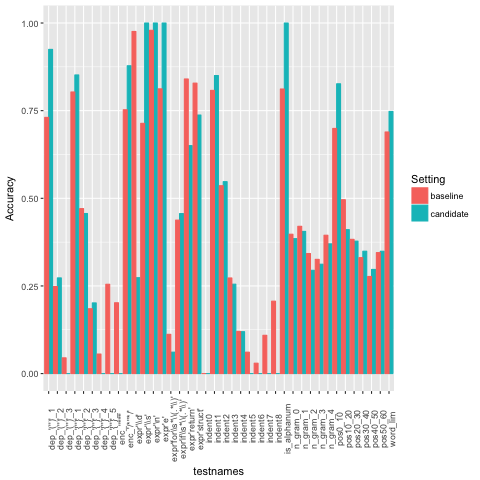

In [ ]:
%%R -i testnames,baseline,candidate,FOLDER_OUT

toplot <- data.frame(testnames, baseline, candidate)
write.csv(toplot, paste0(FOLDER_OUT,'/test_results'),row.names = FALSE)

dat <- gather(toplot, key='Setting', value='Accuracy', -testnames)

p <- ggplot(dat, aes(x=testnames, y=Accuracy, fill=Setting, color=Setting)) +
        geom_bar(stat='identity', position='dodge') +
        theme(axis.text.x = element_text(angle=90))

print(p)
ggsave(paste0(FOLDER_OUT, '/test_scores.pdf'), p, width=40, height=10)

# Kevinizes

In [ ]:
from controllers import control
reload(control)
import verify
reload(verify)

verifier = verify.Verifier(model, feature_neurons, non_feature_neurons)
v_scores = verifier.run(feature_frame_y, X_test, y_test, BATCH_SIZE, sample_size=SAMPLES_VERIFY)

*** Testing the neurons for feature pos0_10
* Computing original accuracy


/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


* Computing baseline accuracies
Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
* Computing candidate accuracies
Round 0


/Users/thib/.virtualenvs/keras/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
{'original': {0.0: [0.47319584561137501], 1.0: [0.53468127181929326]}, 'candidate': {0.0: [0.32872435231824942, 0.40153888020814194, 0.33357368989588676, 0.37816201875530497, 0.40153888020814194, 0.37816201875530497, 0.28873812747317346, 0.37816201875530497], 1.0: [0.39619006300671783, 0.43059117272281849, 0.41577933657414451, 0.45421956699311888, 0.43059117272281849, 0.45421956699311888, 0.30195473790926491, 0.45421956699311888]}, 'baseline': {0.0: [0.45261022642138732, 0.33620499254043323, 0.32918426149920982, 0.35058407867169245, 0.45526754935518177, 0.31193668104371047, 0.33620499254043323, 0.44020669087675479], 1.0: [0.48691144457932128, 0.37542456907220767, 0.43967653229276371, 0.45424335048655218, 0.49925217881275841, 0.42500465694125927, 0.37542456907220767, 0.50587688105147077]}}
*** Testing the neurons for feature pos10_20
* Computing original accuracy
* Computing baseline accuracies
Round 0
Round 1
Round 2
Round 3
Round

* Computing baseline accuracies
Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
* Computing candidate accuracies
Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
{'original': {0.0: [0.49872365836479637], 1.0: [0.2592601570237909]}, 'candidate': {0.0: [0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637], 1.0: [0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909]}, 'baseline': {0.0: [0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637, 0.49872365836479637], 1.0: [0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909, 0.2592601570237909]}}
*** Testing the neurons 

Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
* Computing candidate accuracies
Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
{'original': {0.0: [0.49596119240601266], 1.0: [0.44496321323032817]}, 'candidate': {0.0: [0.42756948217011786, 0.38699674494856046, 0.44547395958259378, 0.39075320152950643, 0.44547395958259378, 0.47645159645735713, 0.41960677507235217, 0.38699674494856046], 1.0: [0.37142649366858371, 0.34908954600737813, 0.40164295215961843, 0.34962458412957093, 0.40164295215961843, 0.433199640737082, 0.36688941200889397, 0.34908954600737813]}, 'baseline': {0.0: [0.47077007321976427, 0.33763377166430381, 0.35388840506385799, 0.33820107126035387, 0.3973216829117, 0.44275758805746834, 0.30587797771293829, 0.35291333830571997], 1.0: [0.43366131298882871, 0.31924512495415358, 0.32338442896225428, 0.29865671469233118, 0.38271443423646412, 0.39993889402074001, 0.23719295494120754, 0.32929422495736266]}}
*** Testing the neurons for feature indent2
* Computing origi

*** Testing the neurons for feature n_gram_0
* Computing original accuracy
* Computing baseline accuracies
Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
* Computing candidate accuracies
Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
{'original': {0.0: [0.48913193271562472], 1.0: [0.27441985476005293]}, 'candidate': {0.0: [0.4713639990531634, 0.4713639990531634, 0.4713639990531634, 0.41281741437668407, 0.4813585761015759, 0.4713639990531634, 0.40839770779027013, 0.40839770779027013], 1.0: [0.2585908705598195, 0.2585908705598195, 0.2585908705598195, 0.20781971854558007, 0.25930853172950297, 0.2585908705598195, 0.22590216427097703, 0.22590216427097703]}, 'baseline': {0.0: [0.43907516466480317, 0.44698961780308355, 0.45654009038600324, 0.4155658141436831, 0.42738238538340573, 0.42577303548773549, 0.45751030266618919, 0.37840592468206946], 1.0: [0.25852838104480919, 0.2540836339727735, 0.26016512336048586, 0.24023879893861208, 0.24675421673017436, 0.255478

*** Testing the neurons for feature expr'return'
* Computing original accuracy
* Computing baseline accuracies
Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
* Computing candidate accuracies
Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
{'original': {0.0: [0.49704420619882428], 1.0: [0.22668984394731334]}, 'candidate': {0.0: [0.34936328554505103, 0.34617932997572726, 0.33323845753335124, 0.33323845753335124, 0.34617932997572726, 0.34936328554505103, 0.48344922706608784, 0.34617932997572726], 1.0: [0.17102768785860589, 0.14906326766703029, 0.17261000448354891, 0.17261000448354891, 0.14906326766703029, 0.17102768785860589, 0.21927734009014552, 0.14906326766703029]}, 'baseline': {0.0: [0.42120957295765205, 0.47198162945040073, 0.49228336044911047, 0.46881133870673619, 0.3991945829774457, 0.45076942043828228, 0.34529469018357623, 0.46069645508924428], 1.0: [0.16387804151885771, 0.19481632299939641, 0.22010099832597177, 0.22531911858865525, 0.2304453734647

In [ ]:
for feat in v_scores:
    print '---', feat
    for setup in v_scores[feat]:
        print '-', setup
        for y in v_scores[feat][setup]:
            s = v_scores[feat][setup][y]
            print y, ':', 'mean:', np.mean(s), '- sd:', np.std(s) 

--- pos30_40
- original
0.0 : mean: 0.505130345136 - sd: 0.0
1.0 : mean: 0.429211426023 - sd: 0.0
- candidate
0.0 : mean: 0.418293041285 - sd: 0.0354238726611
1.0 : mean: 0.353637915068 - sd: 0.0417923514358
- baseline
0.0 : mean: 0.426801144129 - sd: 0.0511161883281
1.0 : mean: 0.362754130371 - sd: 0.0448305323407
--- expr'return'
- original
0.0 : mean: 0.497044206199 - sd: 0.0
1.0 : mean: 0.226689843947 - sd: 0.0
- candidate
0.0 : mean: 0.360898837894 - sd: 0.0467238173281
1.0 : mean: 0.169217815972 - sd: 0.0216625788093
- baseline
0.0 : mean: 0.438780131282 - sd: 0.0448694559065
1.0 : mean: 0.2191751242 - sd: 0.0448044177199
--- expr'\\s'
- original
0.0 : mean: 0.470097335775 - sd: 0.0
1.0 : mean: 0.0446270062216 - sd: 0.0
- candidate
0.0 : mean: 0.406418757034 - sd: 0.0249753517836
1.0 : mean: 0.0437366464364 - sd: 0.00750502132157
- baseline
0.0 : mean: 0.372027197869 - sd: 0.042105565219
1.0 : mean: 0.0466593799555 - sd: 0.00535097468605
--- indent1
- original
0.0 : mean: 0.49596

In [ ]:
verifier.test_diff()

Testing for feature pos30_40
Value 0.0 : Ttest_indResult(statistic=-0.36195492684572905, pvalue=0.72344837730496003)
Value 1.0 : Ttest_indResult(statistic=-0.3935310385753672, pvalue=0.69988411140639273)
Testing for feature expr'return'
Value 0.0 : Ttest_indResult(statistic=-3.1808603789787959, pvalue=0.0066813160572056964)
Value 1.0 : Ttest_indResult(statistic=-2.6558960320963934, pvalue=0.023873291162208009)
Testing for feature expr'\\s'
Value 0.0 : Ttest_indResult(statistic=1.8586553484294326, pvalue=0.089107961935661104)
Value 1.0 : Ttest_indResult(statistic=-0.83894868376435283, pvalue=0.41706388337439515)
Testing for feature indent1
Value 0.0 : Ttest_indResult(statistic=2.0434397991442221, pvalue=0.065305839854009382)
Value 1.0 : Ttest_indResult(statistic=1.5122481901840195, pvalue=0.16056328631271033)
Testing for feature indent0
Value 1.0 : Ttest_indResult(statistic=nan, pvalue=nan)
Testing for feature indent3
Value 0.0 : Ttest_indResult(statistic=-1.7367758888911051, pvalue=0.1

{("dep_'('')'_1",
  0.0): Ttest_indResult(statistic=0.56631397270262374, pvalue=0.58376419100365307),
 ("dep_'('')'_1",
  1.0): Ttest_indResult(statistic=0.62067888596774234, pvalue=0.54782100180380244),
 ("dep_'('')'_2",
  0.0): Ttest_indResult(statistic=-1.3646601912970917, pvalue=0.19490331101241978),
 ("dep_'('')'_2",
  1.0): Ttest_indResult(statistic=-0.77884610995086545, pvalue=0.4490382645288552),
 ("dep_'('')'_3", 0.0): Ttest_indResult(statistic=nan, pvalue=nan),
 ("dep_'('')'_3", 1.0): Ttest_indResult(statistic=nan, pvalue=nan),
 ("dep_'{''}'_1",
  0.0): Ttest_indResult(statistic=-1.5746488761085875, pvalue=0.13802966454923082),
 ("dep_'{''}'_1",
  1.0): Ttest_indResult(statistic=-2.539335730067307, pvalue=0.023824985364647645),
 ("dep_'{''}'_2",
  0.0): Ttest_indResult(statistic=-0.15026130885377786, pvalue=0.88284565719868424),
 ("dep_'{''}'_2",
  1.0): Ttest_indResult(statistic=1.0812193699487089, pvalue=0.29841406711621182),
 ("dep_'{''}'_3",
  0.0): Ttest_indResult(statis

# Post experiment checks

In [ ]:
feat_names = feature_frame_x.names
feat_mat = feature_frame_x.values

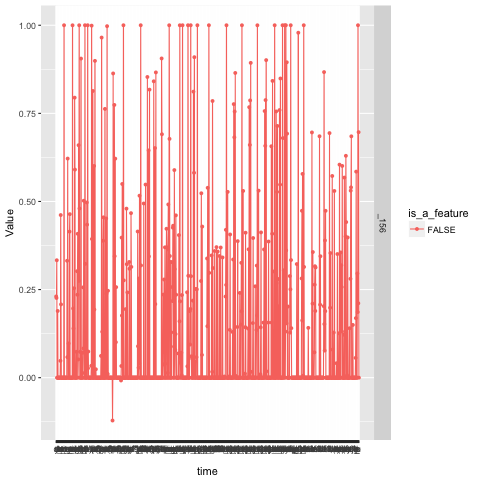

In [ ]:
%%R -i feat_names,X_test_sequence,feat_mat,states

FEATURE <- c('char_i')
NEURON <- c('_156')

MIN_TIME <- 0
MAX_TIME <- 1000

library(ggplot2)
library(scales)
library(dplyr)
library(tidyr)

states_col_names <- paste0('_', 0:(ncol(states)-1))
colnames(states) <- states_col_names
colnames(feat_mat) <- feat_names

to_plot <- cbind(states, feat_mat)
to_plot <- as.data.frame(to_plot)
to_plot[['time']] <- 1:nrow(to_plot)
to_plot <-  gather(to_plot, key='Series', value='Value', -time)
to_plot[['is_a_feature']] <- ! to_plot$Series %in% states_col_names


to_plot <- filter(to_plot, Series %in% states_col_names | is_a_feature)
to_plot <- filter(to_plot, Series %in% c(FEATURE, NEURON))
to_plot <- filter(to_plot, time >= MIN_TIME, time <= MAX_TIME)

labels <- X_test_sequence[MIN_TIME:MAX_TIME]


p <- ggplot(to_plot, aes(x=time, y=Value, fill=is_a_feature, color=is_a_feature, shape = is_a_feature)) +
            scale_x_continuous(breaks = sort(unique(to_plot$time)), labels = labels) +
            #scale_y_continuous(limits = c(-1,1), breaks=c(-1,1)) +
            geom_line() +
            geom_point() +
            facet_grid(Series~., scales="free")
print(p)

fi <- paste0('~/Desktop/focus', paste0(FEATURE, collapse=""), paste0(NEURON, collapse=""), '.pdf')
h <- length(FEATURE) + length(NEURON)
ggsave(fi, p, width=40, height=h)

In [ ]:
reload(feat)
f = feat.regex('return')
f = feat.regex('struct')
f = feat.regex('e')
f = feat.regex('\d')
f = feat.regex('\s')
f = feat.regex('\n')
f = feat.regex('if\s*\(.*\)')
f = feat.regex('for\s*\(.*\)')

t,names = f(X_test_sequence)

# ss = ''
# ff = ''
# for i,c in enumerate(X_test_sequence):
#     if c == '\n':
#         print ss
#         print ff
#         ss = ''
#         ff = ''
#     else:
#         ss += c
#         ff +=str(t[i])[0] # str(np.argmax(t[i,:]))

TypeError: reload() argument must be module